# Clustering task

# Importing Libraries, first look at the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sehriyarmemmedli/binaaz-rent-project")

print("Path to dataset files:", path, '\n'*2)

df = pd.read_csv(path + '/house_rent.csv')
print('shape of all data: ', df.shape, '\n')

Path to dataset files: /root/.cache/kagglehub/datasets/sehriyarmemmedli/binaaz-rent-project/versions/1 


shape of all data:  (33895, 48) 



<ipython-input-2-1c1c0d51794d>:8: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + '/house_rent.csv')


# Cleaning

In [ ]:
# dropping unnecessary columns
df = df.drop(columns=['id_x', 'rel_url', 'estate_rel_url_x', 'datetime_scrape_x', 'currency_x', 'city_when', 'day_x', 'hour_x',\
'img_url', 'billing_cycle_x', 'id_y', 'estate_id', 'estate_rel_url_y', 'datetime_scrape_y', 'description', 'total_price', 'owner_name', 'owner_title',\
'shop_name', 'shop_title', 'address', 'updated', 'views', 'day_y', 'hour_y', 'estate_details_id_x', 'Binanın növü', 'Mərtəbə',\
'attributes', 'estate_details_id_y', 'estate_rel_url', 'extra_info', 'currency_y',\
                      'vip', 'featured', 'lat', 'lng'])

# removing null values pandas way
df = df[~(df['Otaq sayı'].isna())]

df = df[~(df['Təmir'].isna())]

df = df[df['city']=='bakı']

# filling NaN values
df['products_label'] = df.loc[:, 'products_label'].fillna(value='Makler')

df['repair'] = df.loc[:, 'repair'].fillna(value='Təmirsiz')

# Sahe column needed function applying in pandas, it contained str
df['Sahə'] = df['Sahə'].apply(lambda x: x.split(' ')[0]).astype(float)

df['Torpaq sahəsi'] = df['Torpaq sahəsi'].astype(object).fillna(value='0').apply(lambda x: x.split(' ')[0]).astype(float)

# price column followed a log distribution, so log-transformation would help it to follow normal distribution and in scaling part, it will go along well
# since dimensionality reduction methods are based on euclidean distance (most of them)
df['price'] = df['price'].apply(np.log1p)

In [ ]:
df.shape  # what is the shape

(29467, 11)

# Visualization and distribution of the data

In [ ]:
# quick recap of columns' data

for col in df.columns:
  print(df[col].value_counts(normalize=True).sort_values(ascending=False), '\n'*3)

price
6.908755    0.062782
7.313887    0.057488
6.685861    0.052160
7.090910    0.051922
6.552508    0.045339
              ...   
5.262690    0.000034
6.708084    0.000034
9.350189    0.000034
8.659560    0.000034
5.521461    0.000034
Name: proportion, Length: 449, dtype: float64 



location
Şah İsmayıl Xətai m.     0.091764
28 May m.                0.089694
Nəriman Nərimanov m.     0.072793
Elmlər Akademiyası m.    0.058065
Nəsimi r.                0.057386
                           ...   
5-ci mikrorayon q.       0.000034
Pirallahı r.             0.000034
Massiv A q.              0.000034
Sahil q.                 0.000034
Albalılıq q.             0.000034
Name: proportion, Length: 122, dtype: float64 



city
bakı    1.0
Name: proportion, dtype: float64 



repair
Təmirli     0.997726
Təmirsiz    0.002274
Name: proportion, dtype: float64 



products_label
Agentlik    0.766111
Makler      0.233889
Name: proportion, dtype: float64 



billing_cycle_y
ay     0.927376
gün    0.07262

## Visualizing ~ categorical columns

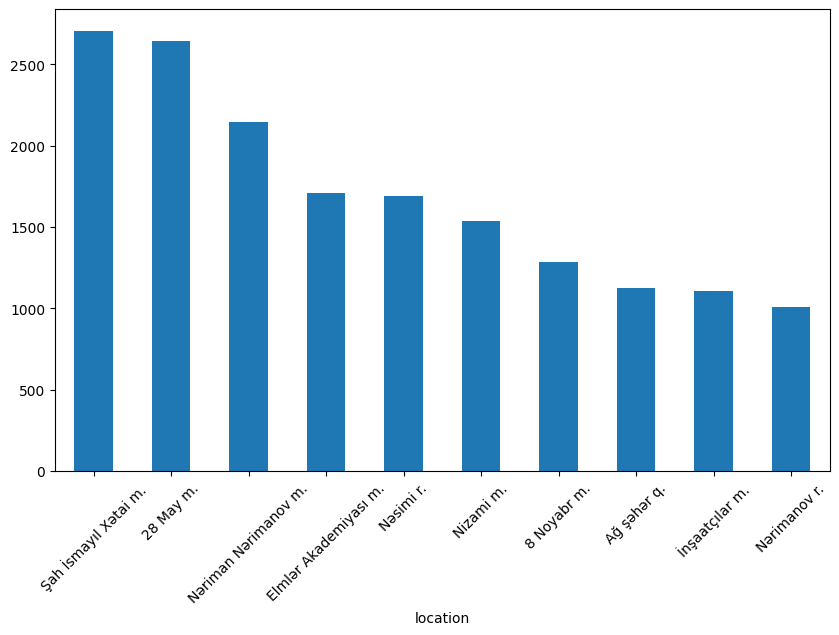

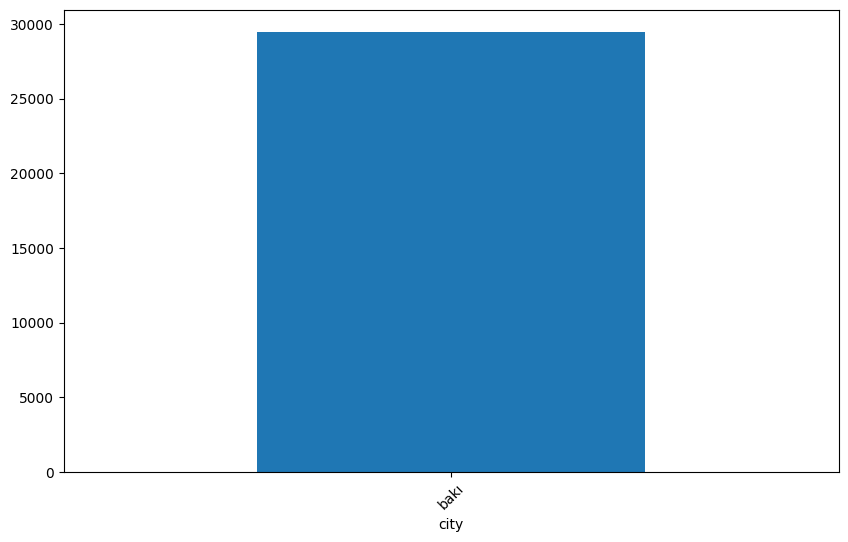

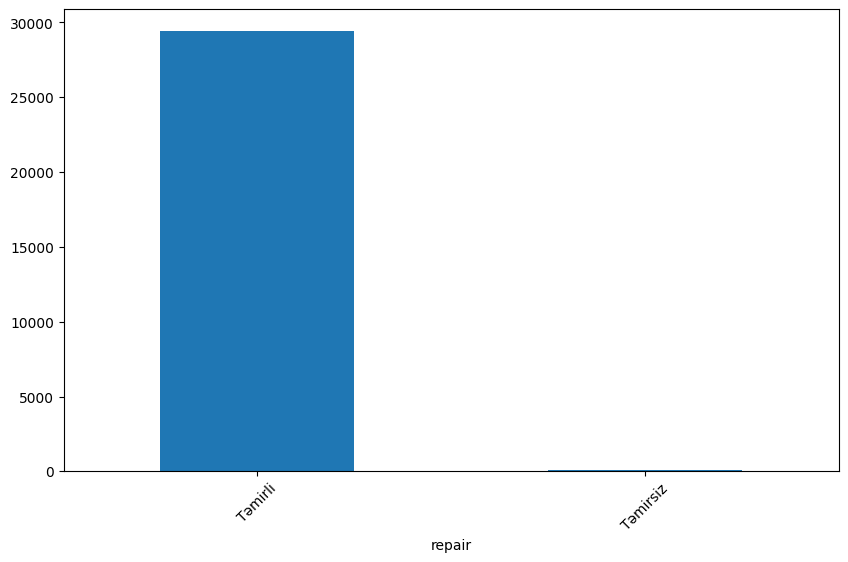

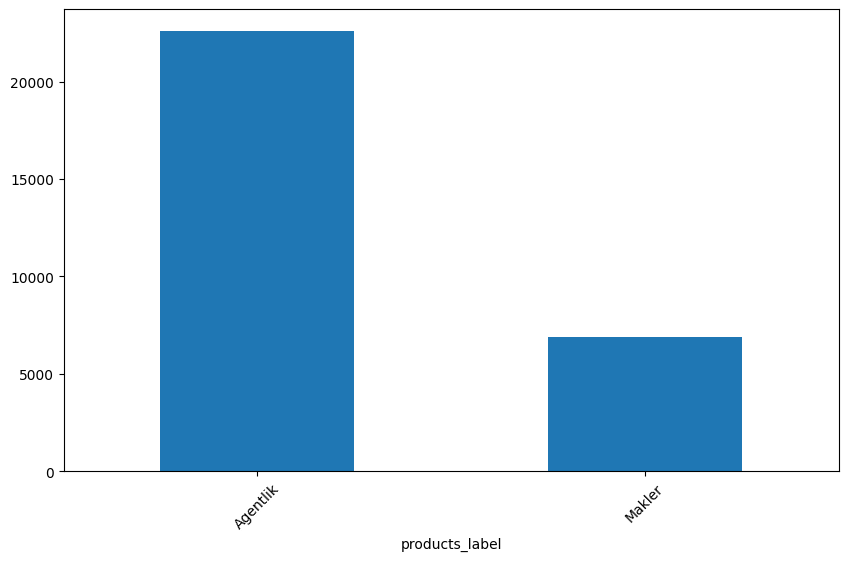

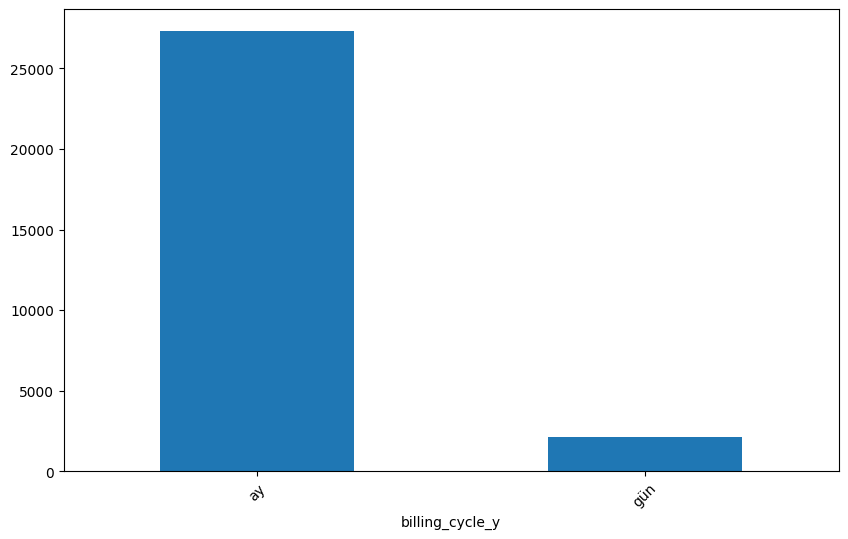

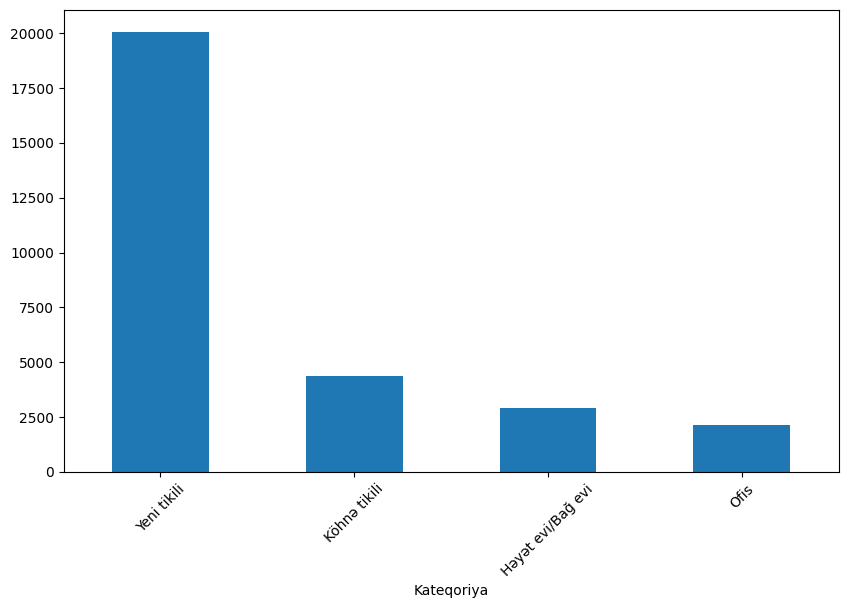

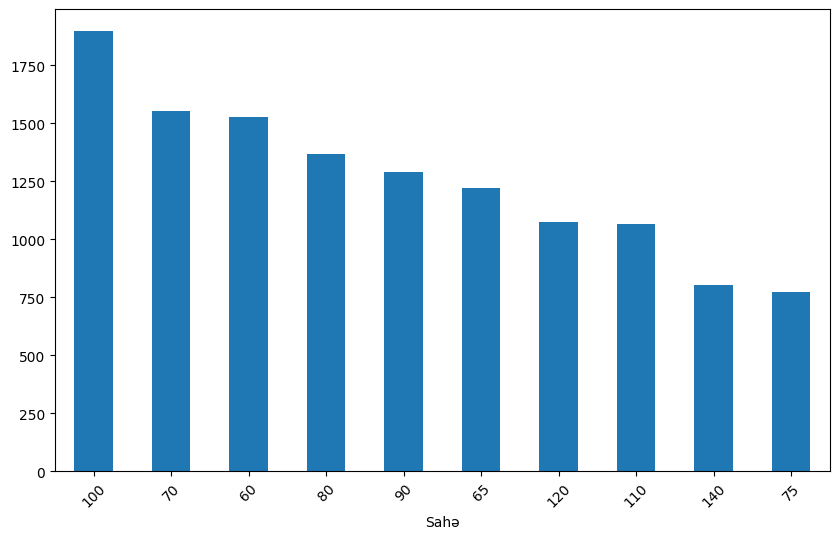

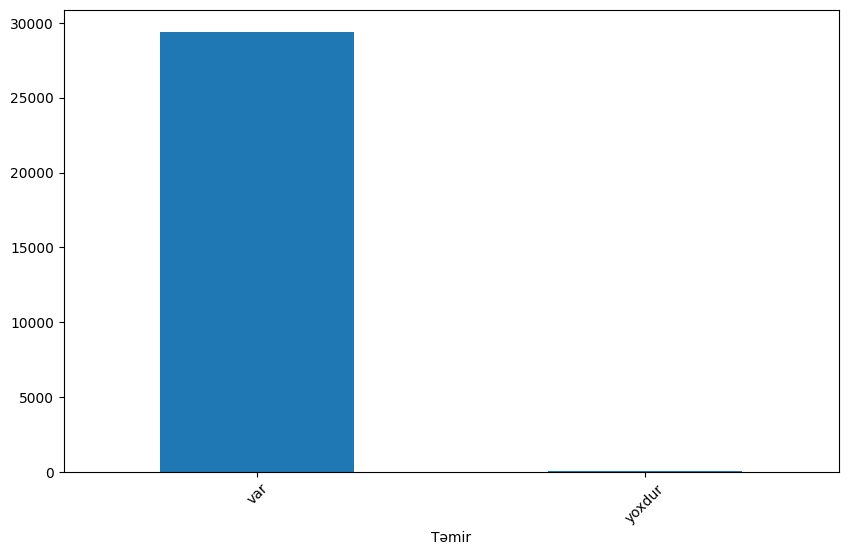

In [ ]:
# visualizing categorical columns in a bar plot

for col in df.select_dtypes(exclude=[np.number]).columns:
  df[col].value_counts(dropna=False).sort_values(ascending=False)[:10].plot.bar(style='plotly', rot=45, figsize=(10, 6))
  plt.show()
  print('\n'*2)

In [ ]:
df.select_dtypes(include=[np.number]).columns  # numerical columns

Index(['price', 'Otaq sayı', 'Sahə', 'Torpaq sahəsi'], dtype='object')

In [ ]:
df.select_dtypes(exclude=[np.number]).columns  # categorical columns

Index(['location', 'city', 'repair', 'products_label', 'billing_cycle_y',
       'Kateqoriya', 'Təmir'],
      dtype='object')

In [ ]:
df['billing_cycle_y'].value_counts(dropna=False)  # just curious

,count
billing_cycle_y,
ay,27327
gün,2140


## Visualizing numerical columns

<Axes: ylabel='Frequency'>

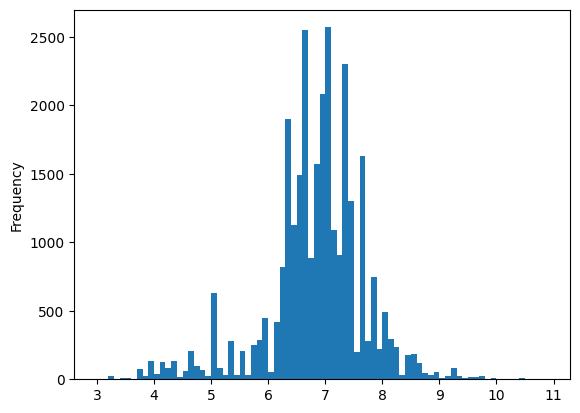

In [ ]:
df['price'].plot.hist(bins=[i/10 for i in range(30, 110)])  # following cells display histograms of numerical columns

<Axes: ylabel='Frequency'>

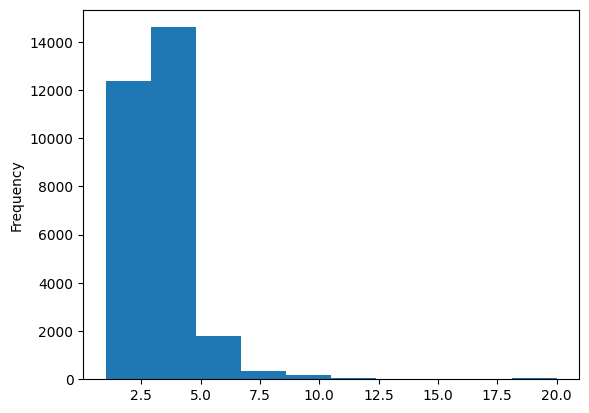

In [ ]:
df['Otaq sayı'].plot.hist()

<Axes: ylabel='Frequency'>

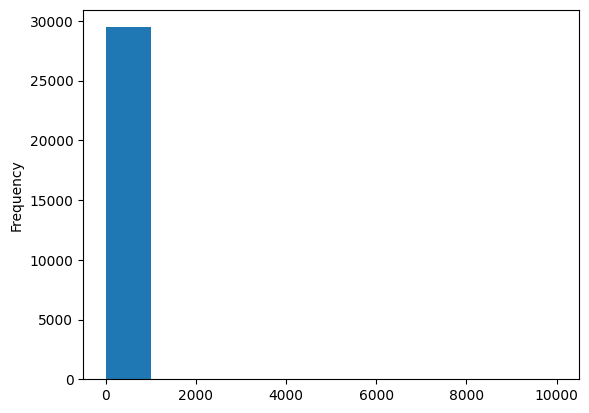

In [ ]:
df['Torpaq sahəsi'].plot.hist()

# PCA, MiniBatchKMeans

minibatchkmeans fits the dataset in batches, great for large datasets.

In [ ]:
# importing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score


# declaring num. and col. columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns
num_cols = list(set(df.columns).difference(set(cat_cols)))


ct = ColumnTransformer(
    [
        ('cat', OneHotEncoder(sparse_output=False), cat_cols),
        ('scaler', StandardScaler(), num_cols),
    ]
)



df_transformed = ct.fit_transform(df)

pca = PCA(n_components=0.95)

df_transformed_reduced = pca.fit_transform(df_transformed)

print('columns before PCA: ', df_transformed.shape[1])
print('columns after PCA: ', df_transformed_reduced.shape[1])


print('\n'*3, 'Plotting', '\n'*3)


# MiniBatchKMeans models, inertias and silhouette scores with n_clusters ranging from 5 to 150, step=5
K_range = range(5, 155, 5)

kmeans_per_k = [MiniBatchKMeans(n_clusters=k, max_iter=20, n_init=15, random_state=42).fit(df_transformed_reduced) for k in K_range]
inertias = [model.inertia_ for model in kmeans_per_k]
sil_scores = [silhouette_score(df_transformed_reduced, model.labels_) for model in kmeans_per_k]

# plotting metrics for kmeans: elbow method is not suitable, but silhouette score is
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('$k$', fontsize='x-large')
plt.ylabel('Inertias', fontsize='x-large')
plt.show()

print('\n'*2)

plt.plot(K_range, sil_scores, 'ro-')
plt.plot(K_range[np.argmax(sil_scores)], np.max(sil_scores), 'yo-')
plt.xlabel('$k$', fontsize='x-large')
plt.ylabel('Silhouette scores', fontsize='x-large')
plt.show()


print('\n'*2)
print(f'best K for KMeans clustering: {K_range[np.argmax(sil_scores)]}')
print(f'best silhouette score: {np.max(sil_scores)}')

Kmeans model performed poorly.
\
\
Because of non-linear relationships present in the data, pca cannot identify them, and that leads to poor clustering performance.

# PCA and MiniBatchKMeans visualization in 2D and 3D

In [ ]:
best_kmeans_model = kmeans_per_k[np.argmax(sil_scores)]  # best model is the model with highest silhouette score

# visualizing in 2D
pca = PCA(n_components=2)
X2D = pca.fit_transform(df_transformed)

plt.scatter(X2D[:, 0], X2D[:, 1])
plt.title('Visualization of data in 2 dimensions')
plt.show()

print('\n'*3)

plt.scatter(X2D[:, 0], X2D[:, 1], c=best_kmeans_model.labels_)
plt.title('Best kmeans model clusters 2D projected data like this:')
plt.show()





print('\n'*6)



# 3D visualizing

print('Data projection in 3 dimensions')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211, projection='3d')

pca = PCA(n_components=3)
X3D = pca.fit_transform(df_transformed)

ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2])
plt.show()

print('\n'*3)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(212, projection='3d')

print('\n'*2, 'How our best model clusters data')
ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2], c=best_kmeans_model.labels_)
plt.show()

## PCA and KMeans limitations and why did they perform poorly


From the graph, it can be seen that PCA with 0.95 explained variance, followed by kmeans model does not perform well.
\
\
There are many factors, but mainly:
\
\
data has high dimensions, compared to visualizable 2 and 3.
\
\
PCA is a linear dimensionality reduction method, and our data has non-linear relationships (also affects KMeans).
\
\
And because of that, kmeans clustered poorly - (Incorrect distribution of data).



# DBSCAN with PCA

In [ ]:
# importing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns
num_cols = df.select_dtypes(include=[np.number]).columns


# transformer instance
ct = ColumnTransformer(
    [
        ('cat', OneHotEncoder(sparse_output=False), cat_cols),
        ('scaler', StandardScaler(), num_cols),
    ]
)



df_transformed = ct.fit_transform(df)  # passing data through ColumnTransformer
df_transformed_reduced = PCA(n_components=0.95).fit_transform(df_transformed)  # applying PCA(0.95)

print(f'column size before PCA: {df_transformed.shape[1]}')  # columns in our data before PCA
print(f'column size after PCA: {df_transformed_reduced.shape[1]}')  # columns in our data after PCA





# DBSCAN has 2 important parameters: eps, and min_samples.
# below code iteratively search for best result, and that will be the model with highest silhouette score.
epsilons = np.linspace(0.01, 1, num=15)
min_samples = np.arange(2, 20, step=3)
dbscan_models = []
sil_scores = []

for eps in epsilons:
  for min_sample in min_samples:
    model = DBSCAN(eps=eps, min_samples=min_sample, n_jobs=-1).fit(df_transformed_reduced)
    dbscan_models.append(model)
    sil_scores.append(silhouette_score(df_transformed_reduced, model.labels_))

dbscan_models, sil_scores = np.array(dbscan_models), np.array(sil_scores)
best_sil_score = np.max(sil_scores)
best_model = dbscan_models[np.argmax(sil_scores)]


print(f'best silhouette score for DBSCAN models: {best_sil_score}', '\n')
print(f'best DBCSAN model: {best_model}', '\n')
print(f'best epsilon value: {best_model.eps}', '\n')
print(f'best min_samples value: {best_model.min_samples}')


print(f'best DBSCAN model thinks that the data has \
{(np.unique(best_model.labels_).size - 1) if -1 in best_model.labels_ else np.unique(best_model.labels_).size} clusters')
# dbscan gives -1 label to its outliers: above code separates outliers from model's predicted clusters.


column size before PCA: 139
column size after PCA: 23



 Plotting 



best silhouette score for DBSCAN models: 0.4345161351986121 

best DBCSAN model: DBSCAN(eps=0.01, min_samples=2, n_jobs=-1) 

best epsilon value: 0.01 

best min_samples value: 2


AttributeError: 'DBSCAN' object has no attribute 'labels'

In [ ]:
best_model.fit(df_transformed_reduced)  # parameters are obtained from previous cell

print(f'best DBSCAN model thinks that the data has \
{(np.unique(best_model.labels_).size - 1) if -1 in best_model.labels_ else np.unique(best_model.labels_).size} clusters')

best DBSCAN model thinks that the data has 5734 clusters


## Why bad scores?

Although DBSCAN returned great value, it thinks that data has too much clusters. Such option cannot be true for this data and it does not make sense.
\
\
It happened because data is not suitable for PCA, because PCA does not understand non-linear relationships.

# PCA and DBSCAN visualization in 2D and 3D

DBSCAN plotting 





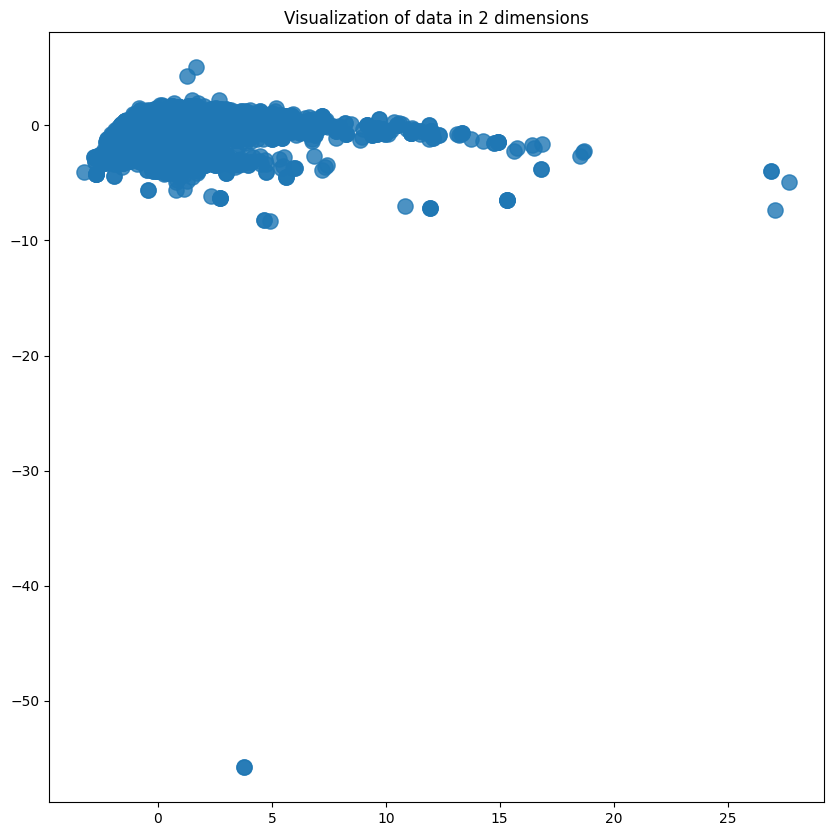

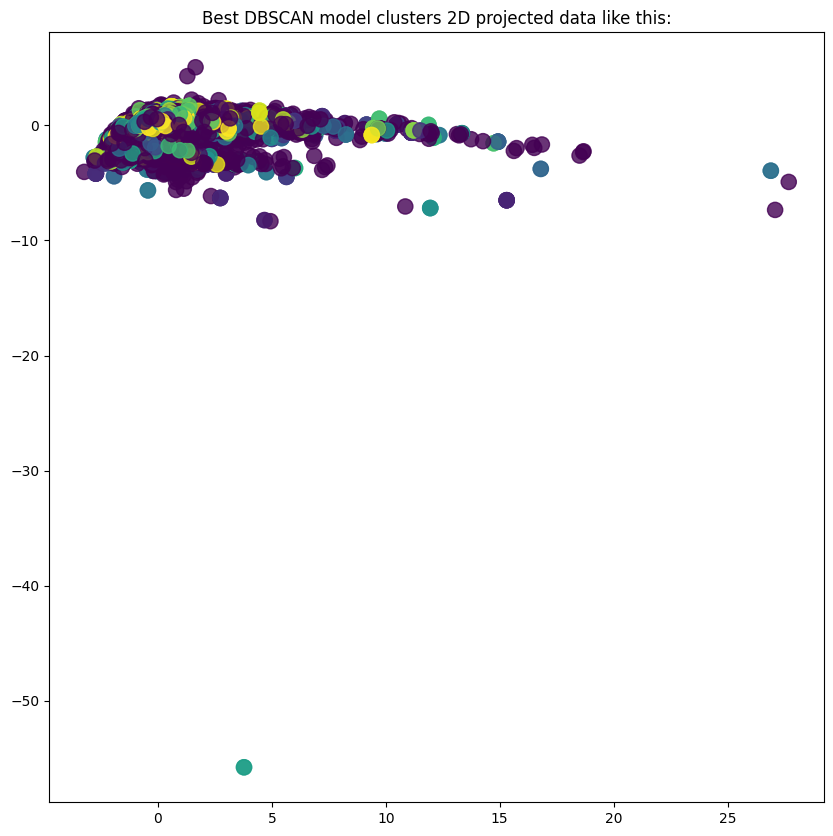








Data projection in 3 dimensions


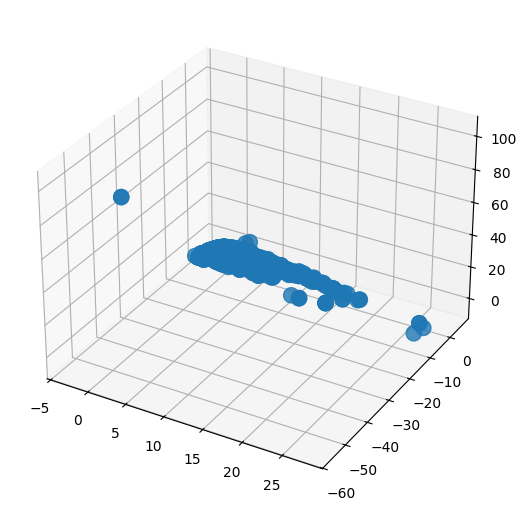







 How our best DBSCAN model clusters data


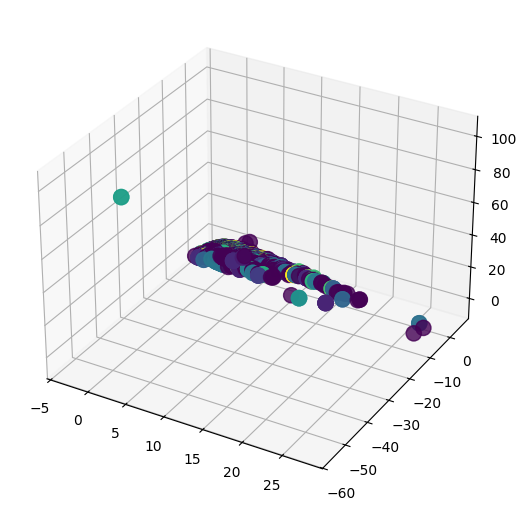

In [ ]:
# This cell plots 2D and 3D visualizations of dbscan model, (colors of samples are model's predictions)

print('DBSCAN plotting', '\n'*3)

pca = PCA(n_components=2)
X2D = pca.fit_transform(df_transformed)

plt.figure(figsize=(10, 10))
plt.scatter(X2D[:, 0], X2D[:, 1], s=120, alpha=0.8)
plt.title('Visualization of data in 2 dimensions')
plt.show()

print('\n'*3)

plt.figure(figsize=(10, 10))
plt.scatter(X2D[:, 0], X2D[:, 1], c=best_model.labels_, s=120, alpha=0.8)
plt.title('Best DBSCAN model clusters 2D projected data like this:')
plt.show()





print('\n'*6)





print('Data projection in 3 dimensions')

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(211, projection='3d')

pca = PCA(n_components=3)
X3D = pca.fit_transform(df_transformed)

ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2], s=120, alpha=0.8)
plt.show()

print('\n'*3)


fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(212, projection='3d')

print('\n'*2, 'How our best DBSCAN model clusters data')
ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2], c=best_model.labels_, s=120, alpha=0.8)
plt.show()

In [ ]:
best_model.labels_.max()

2612

## Why clustering performance was poor?

As seen in previous examples, clustering tends to return huge value of cluster numbers. It is one of the main problems with PCA for high dimensions and non-linear relationships in data. Another problem can be seen at visualization, clusters are not proper, and given the dimensions 2 and 3 compared to ~100*, it is likely to happen.
